In [75]:
!rm -rf IFIC-SummerSchool-2025
!git clone https://github.com/M0V1/IFIC-SummerSchool-2025.git
!pip install  numpy pandas uproot matplotlib mplhep awkward

Cloning into 'IFIC-SummerSchool-2025'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 101 (delta 41), reused 4 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 78.80 MiB | 15.03 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [77]:
!ls IFIC-SummerSchool-2025
!find IFIC-SummerSchool-2025 -name "*.root"

Htobb.ipynb
Htotautau.ipynb
inv.C
ODEO_FEB2025_v0_2J2LMET30_data15_periodD.2J2LMET30.root
ODEO_FEB2025_v0_2J2LMET30_data15_periodF.2J2LMET30.root
ODEO_FEB2025_v0_2J2LMET30_data15_periodH.2J2LMET30.root
ODEO_FEB2025_v0_2J2LMET30_mc_345120.PowhegPy8EG_NNLOPS_nnlo_30_ggH125_tautaul13l7.2J2LMET30.root
ODEO_FEB2025_v0_2J2LMET30_mc_345121.PowhegPy8EG_NNLOPS_nnlo_30_ggH125_tautaulm15hp20.2J2LMET30.root
ODEO_FEB2025_v0_2J2LMET30_mc_345122.PowhegPy8EG_NNLOPS_nnlo_30_ggH125_tautaulp15hm20.2J2LMET30.root
ODEO_FEB2025_v0_2J2LMET30_mc_346190.PowhegPy8EG_NNPDF30_AZNLOCTEQ6L1_VBFH125_tautaul13l7.2J2LMET30.root
ODEO_FEB2025_v0_2J2LMET30_mc_346191.PowhegPy8EG_NNPDF30_AZNLOCTEQ6L1_VBFH125_tautaulm15hp20.2J2LMET30.root
ODEO_FEB2025_v0_2J2LMET30_mc_346192.PowhegPy8EG_NNPDF30_AZNLOCTEQ6L1_VBFH125_tautaulp15hm20.2J2LMET30.root
ODEO_FEB2025_v0_2J2LMET30_mc_346193.PowhegPy8EG_NNPDF30_AZNLOCTEQ6L1_VBFH125_tautauh30h20.2J2LMET30.root
ODEO_FEB2025_v0_2J2LMET30_mc_346343.PhPy8EG_A14NNPDF23_NNPDF30ME_ttH125_allhad

In [78]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from concurrent.futures import ProcessPoolExecutor, as_completed
import time

# Integrated luminosity in inverse picobarns
lumi = 36000.

In [88]:
files = [
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root",   #bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_410471.PhPy8EG_A14_ttbar_hdamp258p75_allhad.2J2LMET30.root",     #bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_345121.PowhegPy8EG_NNLOPS_nnlo_30_ggH125_tautaulm15hp20.2J2LMET30.root", #signal
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_345122.PowhegPy8EG_NNLOPS_nnlo_30_ggH125_tautaulp15hm20.2J2LMET30.root",#signal
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_346343.PhPy8EG_A14NNPDF23_NNPDF30ME_ttH125_allhad.2J2LMET30.root",
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700792.Sh_2214_Ztautau_maxHTpTV2_BFilter.2J2LMET30.root",     #bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_data15_periodF.2J2LMET30.root",  #data
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_346344.PhPy8EG_A14NNPDF23_NNPDF30ME_ttH125_semilep.2J2LMET30.root", #signal
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_data15_periodD.2J2LMET30.root",  #data
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_data15_periodH.2J2LMET30.root",  #data
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700902.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CFilterBVeto.2J2LMET30.root", #bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_345120.PowhegPy8EG_NNLOPS_nnlo_30_ggH125_tautaul13l7.2J2LMET30.root",
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700901.Sh_2214_Ztt_maxHTpTV2_Mll10_40_BFilter.2J2LMET30.root" ,#bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_346190.PowhegPy8EG_NNPDF30_AZNLOCTEQ6L1_VBFH125_tautaul13l7.2J2LMET30.root",
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_346191.PowhegPy8EG_NNPDF30_AZNLOCTEQ6L1_VBFH125_tautaulm15hp20.2J2LMET30.root",
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_346192.PowhegPy8EG_NNPDF30_AZNLOCTEQ6L1_VBFH125_tautaulp15hm20.2J2LMET30.root",
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_346193.PowhegPy8EG_NNPDF30_AZNLOCTEQ6L1_VBFH125_tautauh30h20.2J2LMET30.root"
]

tree_name = "analysis"


In [89]:
def calc_weight(data):
    weight_list = (data["ScaleFactor_TAU"] * data["ScaleFactor_DiTauTRIGGER"] * data["ScaleFactor_PILEUP"] *
                   (data["ScaleFactor_BTAG"] * data["mcWeight"] / data["sum_of_weights"]) *
                   (data["xsec"] * data["filteff"] * data["kfac"] * lumi))
    return weight_list

In [160]:
def cut_trig(trigDT):
    return trigDT

def cut_met_et(met_et):
    return met_et > 40
def cut_eta(tau_eta):
    return ak.sum(abs(tau_eta) < 2.5, axis=1) >= 2
def cut_leading_jet(jet_pt):
    return ak.sum(jet_pt > 40, axis=1) >= 1
def cut_tau_pt(tau_pt):
    return ak.sum(tau_pt > 25, axis=1) >= 2

In [ ]:
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    return (dphi + np.pi) % (2 * np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    dphi = delta_phi(phi1, phi2)
    deta = np.abs(eta1 - eta2)
    return np.sqrt(deta**2 + dphi**2)

def cut_dR(tau_eta, tau_phi):
    # Require at least two taus to compute
    mask = ak.num(tau_eta) >= 2
    eta1 = tau_eta[mask][:, 0]
    eta2 = tau_eta[mask][:, 1]
    phi1 = tau_phi[mask][:, 0]
    phi2 = tau_phi[mask][:, 1]

    dr = delta_r(eta1, phi1, eta2, phi2)

    # apply 0.6 < ΔR < 2.5
    dr_mask = (dr > 0.6) & (dr < 2.5)
    d_r = ak.full_like(mask, False)
    d_r[mask] = dr_mask

    return d_r

In [ ]:
def Hmass(E, pt, eta, phi):
    tau_E = ak.sum(E, axis=1)
    tau_px = ak.sum(pt * np.cos(phi), axis=1)
    tau_py = ak.sum(pt * np.sin(phi), axis=1)
    tau_pz = ak.sum(pt * np.tanh(eta), axis=1)
    Mass = np.sqrt(tau_E**2 - (tau_px**2 + tau_py**2 + tau_pz**2))
    return Mass


In [200]:
def collinear_mass(tau_pt, tau_phi, tau_e, met, met_phi):
    n_events = len(tau_pt)
    m_tt = np.full(n_events, np.nan)


    p0x = tau_pt[:, 0] * np.cos(tau_phi[:, 0])
    p0y = tau_pt[:, 0] * np.sin(tau_phi[:, 0])
    p1x = tau_pt[:, 1] * np.cos(tau_phi[:, 1])
    p1y = tau_pt[:, 1] * np.sin(tau_phi[:, 1])

    met_x = met * np.cos(met_phi)
    met_y = met * np.sin(met_phi)

    for i in range(n_events):
        A = np.array([[p0x[i], p1x[i]],
                      [p0y[i], p1y[i]]])
        b = np.array([met_x[i] + p0x[i] + p1x[i],
                      met_y[i] + p0y[i] + p1y[i]])
        try:
            x = np.linalg.solve(A, b)
            x1, x2 = x[0], x[1]
            if  0<x1 < 1.4 and 0 < x2 < 1.4:

                E_vis0 = tau_e[i, 0]
                E_vis1 = tau_e[i, 1]
                px_vis = p0x[i] + p1x[i]
                py_vis = p0y[i] + p1y[i]

                m_vis2 = (E_vis0 + E_vis1)**2 - (px_vis**2 + py_vis**2)
                if m_vis2 > 0:
                    m_vis = np.sqrt(m_vis2)
                    m_tt[i] = m_vis / np.sqrt(x1 * x2)
        except np.linalg.LinAlgError:
            continue

    return m_tt

In [216]:
def process_file(file_path, tree_name, loop):
    tree = uproot.open(f"{file_path}:{tree_name}")
    sample_data = []

    variables = ["tau_pt", "tau_eta", "tau_phi", "tau_e", "tau_charge", "trigT", "lep_isTrigMatched", "tau_n", "met","met_phi", "lep_type", "lep_isMediumID", "lep_isLooseIso", "jet_e", "jet_pt", "jet_eta", "jet_phi", "jet_btag_quantile", "ScaleFactor_TAU", "ScaleFactor_DiTauTRIGGER", "ScaleFactor_PILEUP", "ScaleFactor_BTAG", "mcWeight", "sum_of_weights", "xsec", "filteff", "kfac"]

    for data in tree.iterate(variables, library="ak", entry_start=int(tree.num_entries * fraction * loop), entry_stop=int(tree.num_entries * fraction * (loop + 1))):
        data = data[cut_tau_pt(data.tau_pt)]
       # data = data[cut_leading_jet(data.jet_pt)]
        #data = data[cut_trig(data.trigDT)]
        #data = data[cut_met_et(data.met)]
        data = data[cut_eta(data.tau_eta)]
        #data = data[cut_dR(data.tau_eta, data.tau_phi)]
        #data = data[Matched_cut(data.lep_isTrigMatched)]
        data['Inv_mass'] = Hmass(data.tau_e, data.tau_pt, data.tau_eta, data.tau_phi) #invariant
        #data['Inv_mass'] = collinear_mass(data.tau_pt, data.tau_phi,data.tau_e, data.met, data.met_phi) #colinear approx

        data['Weight'] = calc_weight(data)
        sample_data.append(data)

    return ak.concatenate(sample_data, axis=0)



In [217]:
def parallel_analysis(file_list, tree_name):
    combined_data = []
    for file_path in file_list:
        with ProcessPoolExecutor() as executor:
            futures = {executor.submit(process_file, file_path, tree_name, i): i for i in range(10)}
            results = []
            for future in as_completed(futures):
                try:
                    results.append(future.result())
                except Exception as e:
                    print(f"Error in file {file_path}, loop {futures[future]}: {e}")
        if results:
            combined_data.append(ak.concatenate(results, axis=0))

    return ak.concatenate(combined_data, axis=0) if combined_data else ak.Array([])


In [218]:
# Main analysis loop
start_all = time.time()
fraction = 1
print("The analysis has started")

bkg_files = [
    files[0],  # Ztt_maxHTpTV2_Mll10_40_CVetoBVeto
    files[1],  # ttbar_allhad
    files[5],  # Ztautau_maxHTpTV2_BFilter
    files[10], # Ztt_maxHTpTV2_CFilterBVeto
    files[12]  # Ztt_maxHTpTV2_BFilter
]

signal_files = [
    files[2],  # ggH125_tautaulm15hp20
    files[3],  # ggH125_tautaulp15hm20
    files[11], # ggH125_tautaul13l7
    files[4],  # ttH125_allhad
    files[7],  # ttH125_semilep
    files[13],
    files[14],
    files[15],
    files[16],
]

data_files = [
    #files[6],  # data15_periodF
    #files[8],  # data15_periodD
    files[9],  # data15_periodH


]

bkg_data = parallel_analysis(bkg_files, tree_name)
signal_data = parallel_analysis(signal_files, tree_name)
data_data = parallel_analysis(data_files, tree_name)


print(data_data)

The analysis has started
Error in file IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root, loop 1: reduce() of empty iterable with no initial value
Error in file IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root, loop 2: reduce() of empty iterable with no initial value
Error in file IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root, loop 3: reduce() of empty iterable with no initial value
Error in file IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root, loop 4: reduce() of empty iterable with no initial value
Error in file IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root, loop 5: reduce() of empty iterable with no initial value
Error in file IFIC-SummerSchool-202

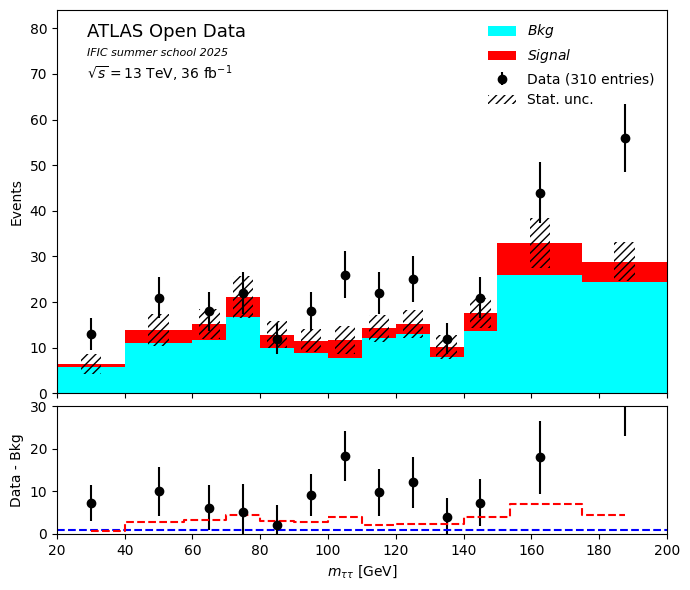

In [219]:

def plot_data(bkg, signal, data, fit=True):
    xmin, xmax, step_size = 20, 200, 6
    #bin_edges = np.arange(xmin, xmax + step_size, step_size)
    bin_edges = np.array([20, 40, 60, 70, 80,90, 100,110, 120, 130,140, 150, 175, 200])
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2


    data_y, _ = np.histogram(data['Inv_mass'], bins=bin_edges)
    data_yerr = np.sqrt(data_y)


    bkg_y, _ = np.histogram(bkg['Inv_mass'], bins=bin_edges, weights=bkg['Weight'])
    signal_y, _ = np.histogram(signal['Inv_mass'], bins=bin_edges, weights=signal['Weight'])


    stacked_mc = np.vstack([bkg_y, signal_y])
    total_mc = np.sum(stacked_mc, axis=0)


    total_mc_err = np.sqrt(
        np.histogram(bkg['Inv_mass'], bins=bin_edges, weights=bkg['Weight']**2)[0] +
        np.histogram(signal['Inv_mass'], bins=bin_edges, weights=signal['Weight']**2)[0]
    )

    fig, (main_ax, ratio_ax) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    main_ax.errorbar(bin_centres, data_y, yerr=data_yerr, fmt='ko', label=f'Data ({sum(data_y)} entries)')


    main_ax.hist([bkg['Inv_mass'], signal['Inv_mass']],
                 bins=bin_edges,
                 weights=[bkg['Weight'], signal['Weight']],
                 stacked=True,
                 color=['cyan', 'red'],
                 label=[r'$Bkg$', r'$Signal$'])


    main_ax.bar(bin_centres, 2 * total_mc_err, alpha=0.5, bottom=total_mc - total_mc_err,
                color='none', hatch="////", width=step_size, label='Stat. unc.')

    main_ax.set_xlim(xmin, xmax)
    main_ax.set_ylim(0, max(max(data_y), max(total_mc)) * 1.5)
    main_ax.set_ylabel("Events")
    main_ax.text(0.05, 0.93, 'ATLAS Open Data', transform=main_ax.transAxes, fontsize=13)
    main_ax.text(0.05, 0.88, 'IFIC summer school 2025', transform=main_ax.transAxes, style='italic', fontsize=8)
    main_ax.text(0.05, 0.82, r'$\sqrt{s}=13$ TeV, 36 fb$^{-1}$', transform=main_ax.transAxes)
    main_ax.legend(frameon=False)


    #ratio = data_y / total_mc
    ratio = data_y -bkg_y
    ratio_err =  np.sqrt(data_yerr**2+np.histogram(bkg['Inv_mass'], bins=bin_edges, weights=bkg['Weight']**2)[0])

    ratio_ax.errorbar(bin_centres, ratio, yerr=ratio_err, fmt='ko')
    ratio_ax.axhline(1, color='blue', linestyle='--')
    ratio_ax.step(bin_centres, signal_y, where='mid', color='red', linestyle='--', label='Signal MC')

    ratio_ax.set_ylabel("Data - Bkg")
    ratio_ax.set_ylim(0, 30)
    ratio_ax.set_xlabel(r"$m_{\tau\tau}$ [GeV]")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)
    plt.show()


plot_data(bkg_data, signal_data, data_data)


Fit failed: could not converge.


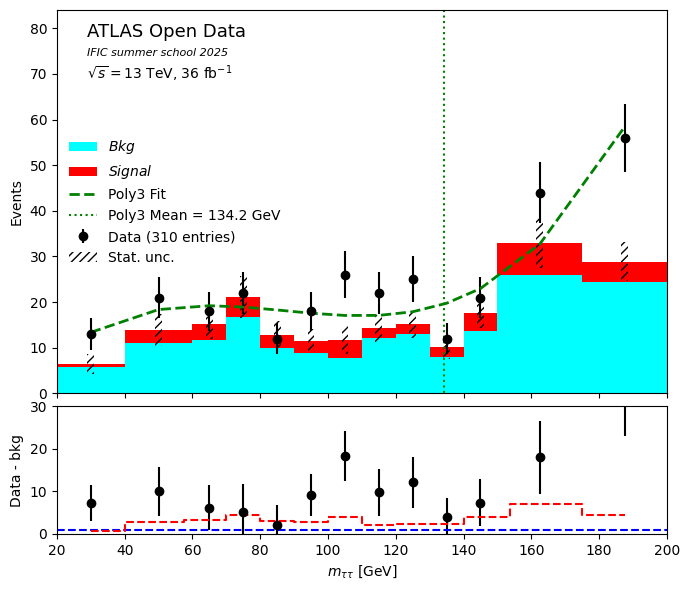

In [220]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from scipy.optimize import curve_fit
from scipy.integrate import quad
# Gaussian
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

#polynomial
def poly2(x, a, b, c):
    return a * x**2 + b * x + c

def poly3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def plot_data(bkg, signal, data, fit=True):
    xmin, xmax, step_size = 20, 200, 2
    #bin_edges = np.arange(xmin, xmax + step_size, step_size)
    bin_edges = np.array([20, 40, 60, 70, 80,90, 100,110, 120, 130,140, 150, 175, 200])
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

    data_y, _ = np.histogram(data['Inv_mass'], bins=bin_edges)
    data_yerr = np.sqrt(data_y)

    bkg_y, _ = np.histogram(bkg['Inv_mass'], bins=bin_edges, weights=bkg['Weight'])
    signal_y, _ = np.histogram(signal['Inv_mass'], bins=bin_edges, weights=signal['Weight'])

    stacked_mc = np.vstack([bkg_y, signal_y])
    total_mc = np.sum(stacked_mc, axis=0)

    total_mc_err = np.sqrt(
        np.histogram(bkg['Inv_mass'], bins=bin_edges, weights=bkg['Weight']**2)[0] +
        np.histogram(signal['Inv_mass'], bins=bin_edges, weights=signal['Weight']**2)[0]
    )

    fig, (main_ax, ratio_ax) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    main_ax.errorbar(bin_centres, data_y, yerr=data_yerr, fmt='ko', label=f'Data ({sum(data_y)} entries)')


    main_ax.hist([bkg['Inv_mass'], signal['Inv_mass']],
                 bins=bin_edges,
                 weights=[bkg['Weight'], signal['Weight']],
                 stacked=True,
                 color=['cyan', 'red'],
                 label=[r'$Bkg$', r'$Signal$'])

   #stat error
    main_ax.bar(bin_centres, 2 * total_mc_err, alpha=0.5, bottom=total_mc - total_mc_err,
                color='none', hatch="////", width=step_size, label='Stat. unc.')

    # Fit
    # Fit
    if fit:
       mask = data_y > 0
       try:
          popt, pcov = curve_fit(gaussian, bin_centres[mask], data_y[mask], p0=[max(data_y), 125, 10], sigma=data_yerr[mask])
          fit_curve = gaussian(bin_centres, *popt)
          main_ax.plot(bin_centres, fit_curve, 'm--', linewidth=2, label=f'Gaussian Fit\n$\mu$={popt[1]:.1f}, $\sigma$={popt[2]:.1f}')
       except RuntimeError:
          print("Fit failed: could not converge.")

       try:
          popt_poly, pcov_poly = curve_fit(poly3, bin_centres[mask], data_y[mask], sigma=data_yerr[mask])
          fit_poly_curve = poly3(bin_centres, *popt_poly)
          main_ax.plot(bin_centres, fit_poly_curve, 'g--', linewidth=2, label=f'Poly3 Fit')

          def poly3_fit(x): return poly3(x, *popt_poly)
          def x_poly3(x): return x * poly3_fit(x)

          x_min_int, x_max_int = bin_edges[0], bin_edges[-1]
          integral_f, _ = quad(poly3_fit, x_min_int, x_max_int)
          integral_xf, _ = quad(x_poly3, x_min_int, x_max_int)

          mean_poly3 = integral_xf / integral_f if integral_f != 0 else float('nan')
          main_ax.axvline(mean_poly3, color='green', linestyle=':', label=f'Poly3 Mean = {mean_poly3:.1f} GeV')

       except RuntimeError:
            print("Polynomial fit failed.")

    main_ax.set_xlim(xmin, xmax)
    main_ax.set_ylim(0, max(max(data_y), max(total_mc)) * 1.5)
    main_ax.set_ylabel("Events")
    main_ax.text(0.05, 0.93, 'ATLAS Open Data', transform=main_ax.transAxes, fontsize=13)
    main_ax.text(0.05, 0.88, 'IFIC summer school 2025', transform=main_ax.transAxes, style='italic', fontsize=8)
    main_ax.text(0.05, 0.82, r'$\sqrt{s}=13$ TeV, 36 fb$^{-1}$', transform=main_ax.transAxes)
    main_ax.legend(frameon=False)

    ratio = data_y -bkg_y

    ratio_err =np.sqrt(data_yerr**2+np.histogram(bkg['Inv_mass'], bins=bin_edges, weights=bkg['Weight']**2)[0]) #np.abs(ratio * np.sqrt((data_yerr / data_y)**2 + (total_mc_err / total_mc)**2))
    ratio_ax.errorbar(bin_centres, ratio, yerr=ratio_err, fmt='ko')
    ratio_ax.axhline(1, color='blue', linestyle='--')
    ratio_ax.set_ylabel("Data - bkg")
    ratio_ax.step(bin_centres, signal_y, where='mid', color='red', linestyle='--', label='Signal MC')

    ratio_ax.set_ylim(0, 30)
    ratio_ax.set_xlabel(r"$m_{\tau\tau}$ [GeV]")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)
    plt.show()

plot_data(bkg_data, signal_data, data_data)